In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from src.data import ClassificationDataset
from src.utils import compute_score
from sklearn.dummy import DummyClassifier

%load_ext autoreload
%autoreaload 2

UsageError: Line magic function `%autoreaload` not found.


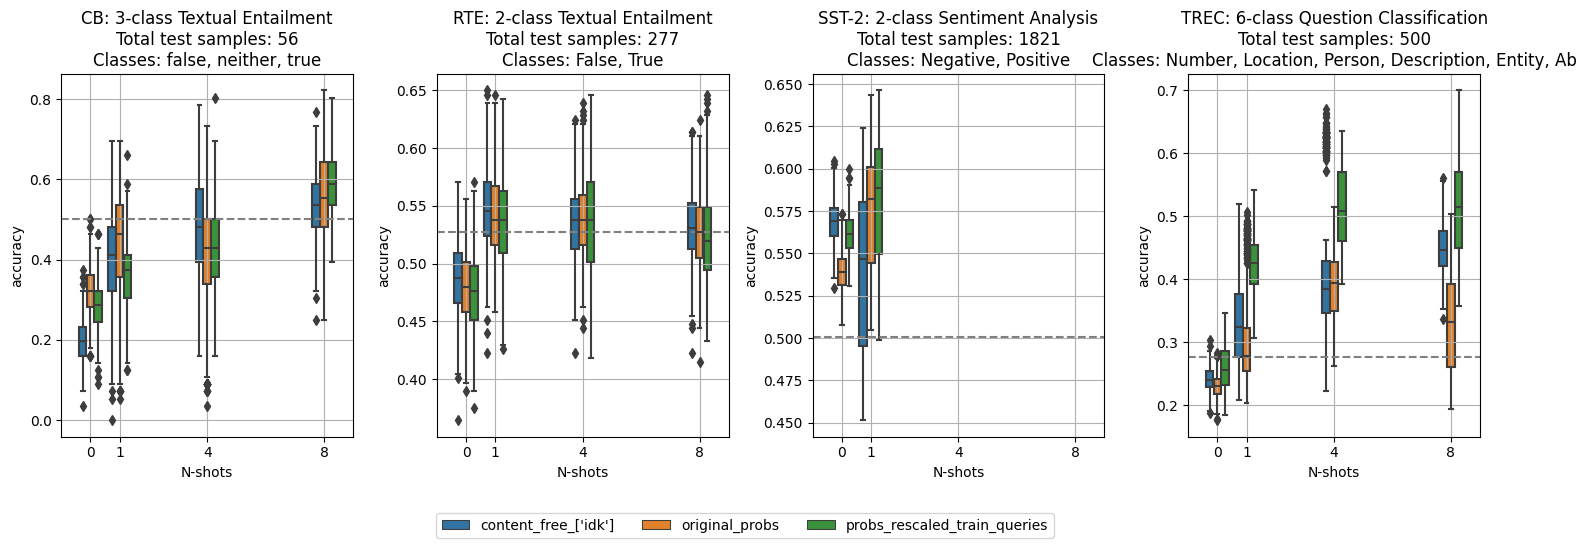

In [20]:
def dataset2description(dataset_name):
    dataset = ClassificationDataset("./",None,dataset=dataset_name,n_shot=0,random_state=None)
    description = dataset.dataset2short[dataset_name] + ": " + dataset.description + f"\nTotal test samples: {sum(dataset.test_samples.values())}" + "\nClasses: " + ", ".join(dataset.test_samples.keys())
    return description

def dataset2baseline(dataset_name, score="accuracy"):
    dataset = ClassificationDataset("./",None,dataset=dataset_name,n_shot=0,random_state=None)
    dummy_classifier = DummyClassifier(strategy="most_frequent")
    train_labels = dataset._data['test_labels'] 
    test_labels = dataset._data['test_labels']
    dummy_classifier.fit(np.zeros((len(train_labels),1)), train_labels)
    predictions = dummy_classifier.predict(np.zeros((len(test_labels),1)))
    score = compute_score(test_labels, predictions, bootstrap=False, score=score, random_state=None)
    return score
    


def read_results(root_dir, experiment_name):
    score_results = pd.read_csv(os.path.join(root_dir, "results", f"{experiment_name}_results.csv"), index_col=None)
    for column in score_results.columns:
        if "score:" in column:
            score_name = column.split(":")[1]
            break
    return score_results, score_name


def plot_score_vs_nshots_std(score_results, score="accuracy"):
    score_results = score_results.sort_values(["model", "dataset", "eval_split", "n_shots", "output_prob_type"])
    datasets = score_results["dataset"].unique()
    n_shots = score_results["n_shots"].unique()
    score_results = score_results.groupby(["model", "dataset", "eval_split", "n_shots", "output_prob_type"]).agg({
        f"score:{score}": ["mean", "std"], 
    })
    fig, ax = plt.subplots(1, len(datasets), figsize=(15, 5))
    for i, dataset in enumerate(datasets):
        # Plot acc vs nshots for each output_prob_type
        for output_prob_type in score_results.reset_index()["output_prob_type"].unique():
            mean = score_results.loc[("gpt2-xl", dataset, "test", slice(None), output_prob_type), (f"score:{score}", "mean")]
            std = score_results.loc[("gpt2-xl", dataset, "test", slice(None), output_prob_type), (f"score:{score}", "std")]
            ax[i].plot(n_shots, mean, label=output_prob_type)
            ax[i].fill_between(n_shots, mean - std, mean + std, alpha=0.2)
        ax[i].set_title(dataset)
        ax[i].set_xlabel("n_shots")
        ax[i].set_xticks(n_shots)
        ax[i].set_ylabel(score)
        ax[i].legend()
        ax[i].grid()
    fig.tight_layout()


def plot_score_vs_nshots_q95(score_results, score="accuracy"):
    score_results = score_results.sort_values(["model", "dataset", "eval_split", "n_shots", "output_prob_type"])
    datasets = score_results["dataset"].unique()
    n_shots = score_results["n_shots"].unique()
    def q95(x): 
        return x.quantile(0.95)
    score_results = score_results.groupby(["model", "dataset", "eval_split", "n_shots", 
    "output_prob_type"]).agg({
        f"score:{score}": ["mean", q95], 
    })
    fig, ax = plt.subplots(1, len(datasets), figsize=(15, 5))
    for i, dataset in enumerate(datasets):
        # Plot acc vs nshots for each output_prob_type
        for output_prob_type in score_results.reset_index()["output_prob_type"].unique():
            mean = score_results.loc[("gpt2-xl", dataset, "test", slice(None), output_prob_type), (f"score:{score}", "mean")]
            q95 = score_results.loc[("gpt2-xl", dataset, "test", slice(None), output_prob_type), (f"score:{score}", "q95")]
            ax[i].plot(n_shots, mean, label=output_prob_type)
            ax[i].fill_between(n_shots, mean - q95/2, mean + q95/2, alpha=0.2)
        ax[i].set_title(dataset)
        ax[i].set_xlabel("n_shots")
        ax[i].set_xticks(n_shots)
        ax[i].set_ylabel(score)
        ax[i].legend()
        ax[i].grid()
    fig.tight_layout()


def plot_score_vs_nshots_boxplot(score_results, score="accuracy"):
    score_results = score_results.sort_values(["model", "dataset", "eval_split", "n_shots", "output_prob_type"])
    score_results = score_results.loc[score_results["output_prob_type"].isin(["original_probs","probs_rescaled_train_queries","content_free_['idk']"]),:]
    datasets = score_results["dataset"].unique()
    n_shots = score_results["n_shots"].unique()
    output_prob_type = score_results["output_prob_type"].unique()
    fig, ax = plt.subplots(1, len(datasets), figsize=(15, 5), sharey=False)
    for i, dataset in enumerate(datasets):
        data = score_results.loc[
            (score_results.model == "gpt2-xl") & \
            (score_results.dataset == dataset) & \
            (score_results.eval_split == "test"),
            ["n_shots", "output_prob_type", f"score:{score}"]
        ]
        ax[i] = sns.boxplot(
            data=data, 
            x="n_shots", 
            y=f"score:{score}", 
            hue="output_prob_type", 
            ax=ax[i],
            order=np.arange(0,max(n_shots)+1)
        )
        ax[i].hlines(dataset2baseline(dataset), n_shots[0]-1, n_shots[-1]+1, linestyles="dashed", colors="gray")
        ax[i].set_title(dataset2description(dataset))
        ax[i].set_xticks(n_shots)
        ax[i].set_xlabel("N-shots")
        ax[i].set_xlim(-1, max(n_shots)+1)
        ax[i].set_ylabel(score)
        # ax[i].set_ylim(0, 1)
        ax[i].grid()
        ax[i].get_legend().remove()

    # add legend
    handles, labels = ax[i].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(output_prob_type), bbox_to_anchor=(0.5, -0.1))
    fig.tight_layout()


root_dir = "./"
experiment = "gpt2-xl_n100"
results, score = read_results(root_dir, experiment)
# plot_score_vs_nshots_std(results, score)
# plot_score_vs_nshots_q95(results, score)
plot_score_vs_nshots_boxplot(results, score)

In [8]:
results.loc[
    (results.model == "gpt2-xl") & \
    (results.dataset == "cb") & \
    (results.eval_split == "test") & \
    (results.n_shots == 0) & \
    (results.output_prob_type == "probs_rescaled_train_queries"),:
]

,dataset,eval_split,model,n_shots,num_train_samples,random_state,output_prob_type,score:accuracy
1,cb,test,gpt2-xl,0,100,89588,probs_rescaled_train_queries,0.303571
5,cb,test,gpt2-xl,0,100,96930,probs_rescaled_train_queries,0.267857
9,cb,test,gpt2-xl,0,100,58213,probs_rescaled_train_queries,0.285714
13,cb,test,gpt2-xl,0,100,14937,probs_rescaled_train_queries,0.267857
17,cb,test,gpt2-xl,0,100,52334,probs_rescaled_train_queries,0.285714
